In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_theme()

In [290]:
# load data
df = pd.read_csv('../datasets/EURUSD tick dec 2023/tick.csv', header=None)
df.columns = ['timestamp', 'bid', 'ask', 'volume']
# parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d %H%M%S%f')

# add features
df['date'] = df['timestamp'].dt.date
df['time'] = df['timestamp'].dt.time
df['hour'] = df['timestamp'].dt.hour
df['wday'] = df['timestamp'].dt.day_name()

# spread
df['spread'] = df['ask'] - df['bid']
df['mid'] = (df['ask'] + df['bid']) / 2
df['ret'] = np.log(df['mid']).diff()

# drop first row since it has ret NaN
df = df.dropna()

Forex globally is open from Sunday 5PM EST to Friday 5PM EST, with no stopping. Is it closed from Friday 5PM EST to Sunday 5PM EST. Therefore it is closed 48h per week. In addition, it is closed on Christmas and New Year's Eve.

## Preliminary stats

In [291]:
bid_change = (df['bid'].shift(-1)!=df['bid']).mean()
ask_change = (df['ask'].shift(-1)!=df['ask']).mean()

print(f'bid change: {100*bid_change:.0f}%')
print(f'ask change: {100*ask_change:.0f}%')

bid change: 64%
ask change: 66%


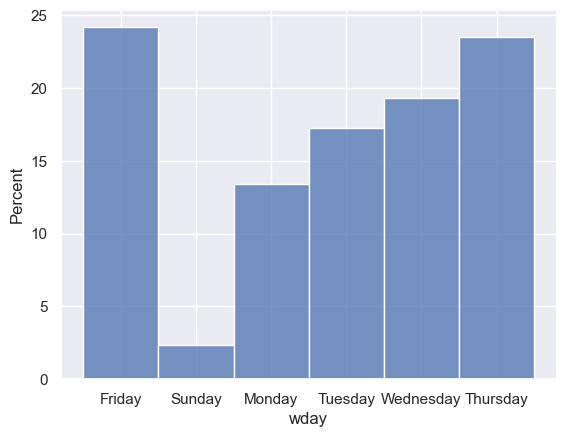

In [292]:
sns.histplot(df['wday'], bins=6, stat='percent')
plt.show()

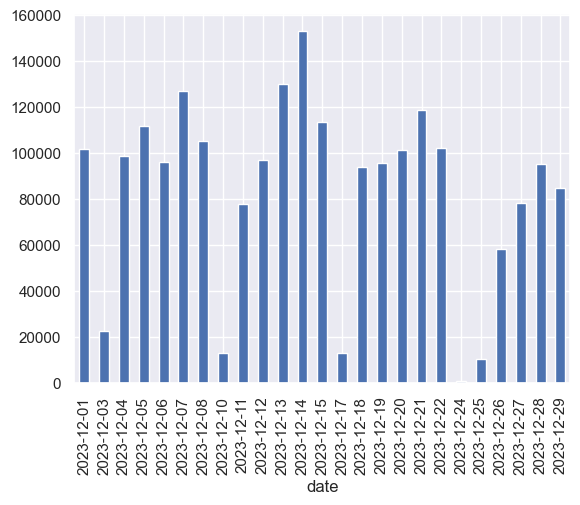

In [293]:
df.groupby('date').size().plot(kind='bar')
plt.show()

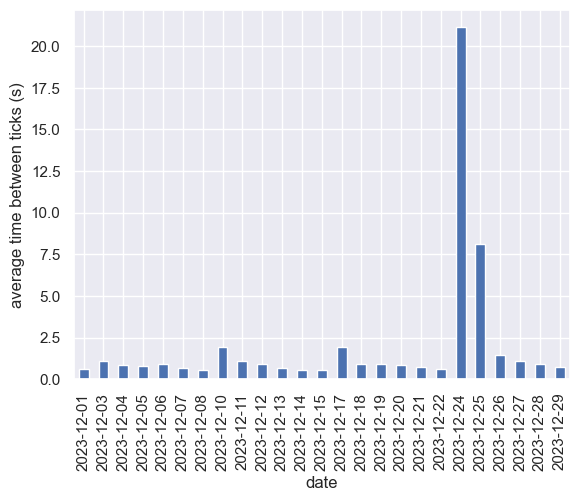

In [294]:
df.groupby('date')['timestamp'].apply(lambda x: x.diff().mean()).dt.total_seconds().plot(kind='bar')
plt.ylabel('average time between ticks (s)')
plt.show()

Very low activity on the 24th and 25th because it's Christmas! (so Forex is closed)

In [295]:
day_chosen = pd.to_datetime('2023-12-01').date()
oneday = df[df['date']==day_chosen]
avg_tick_time = oneday['timestamp'].diff().mean().total_seconds()

print(f'day chosen: {day_chosen}')
print(f'average time between ticks: {avg_tick_time:.2f} seconds')
print(f'number of ticks: {oneday.shape[0]}')

day chosen: 2023-12-01
average time between ticks: 0.60 seconds
number of ticks: 101792


C:\Users\gecre\AppData\Local\Temp\ipykernel_12896\2981400821.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


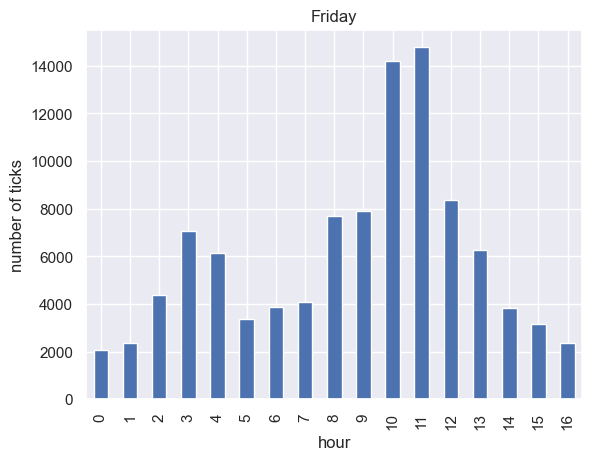

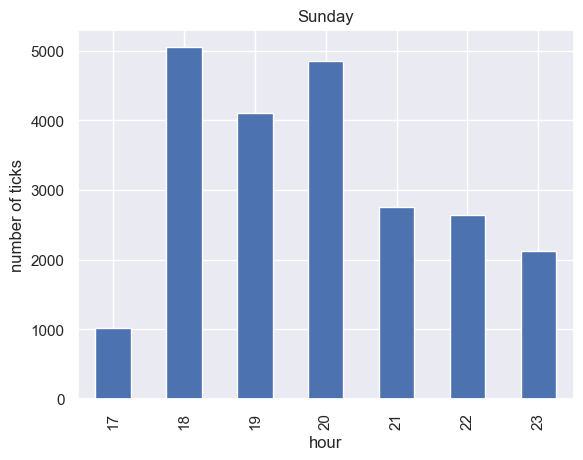

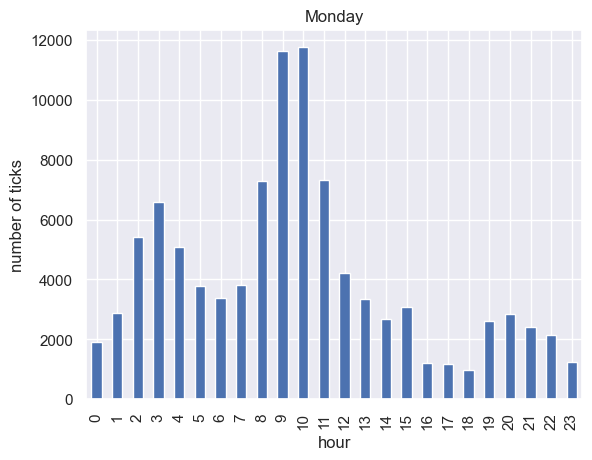

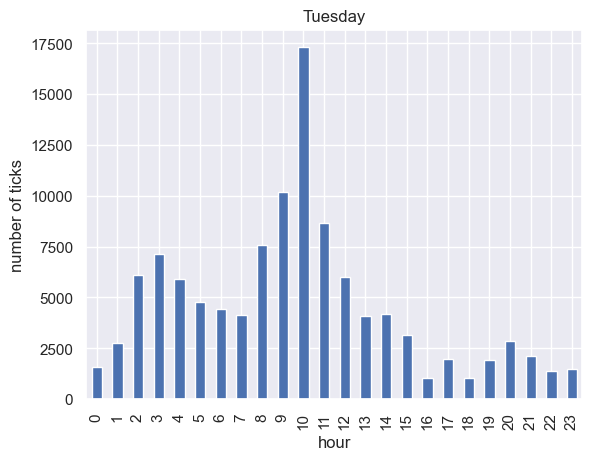

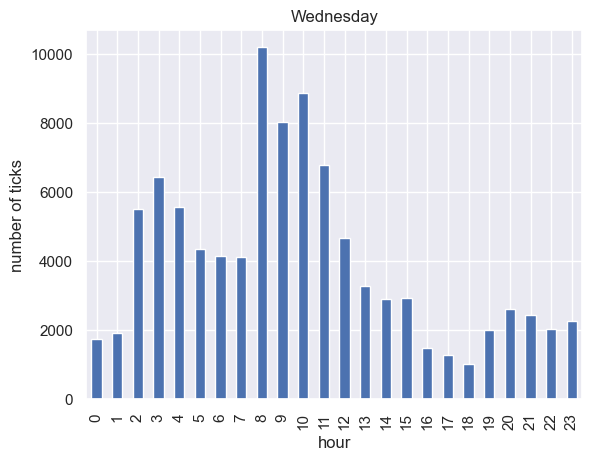

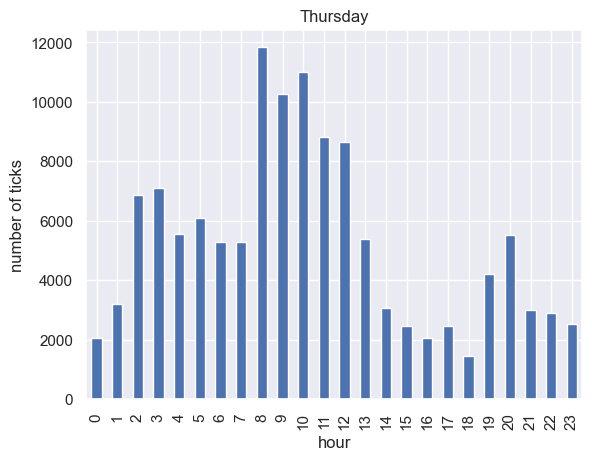

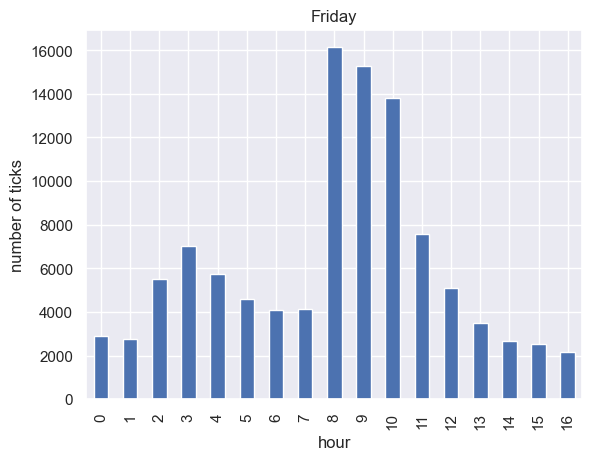

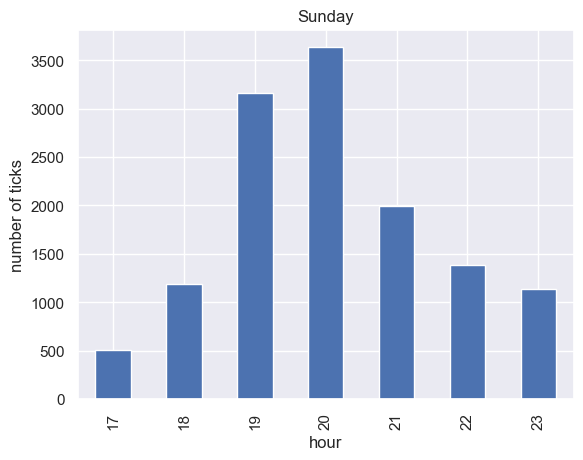

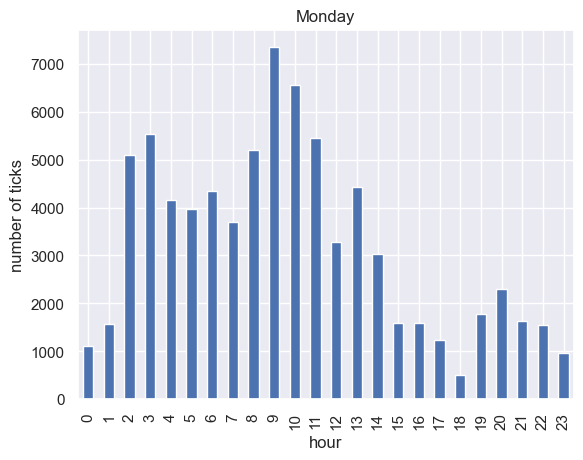

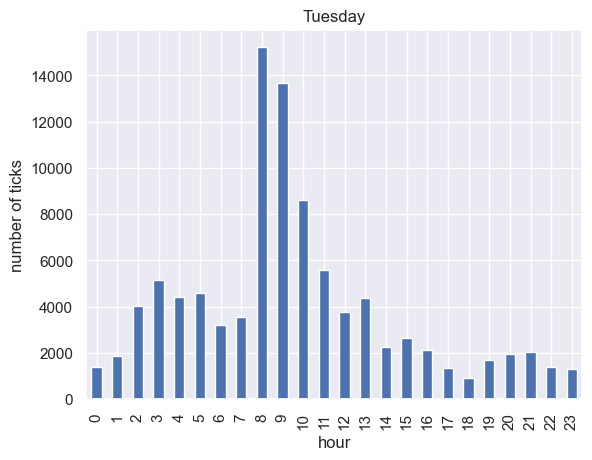

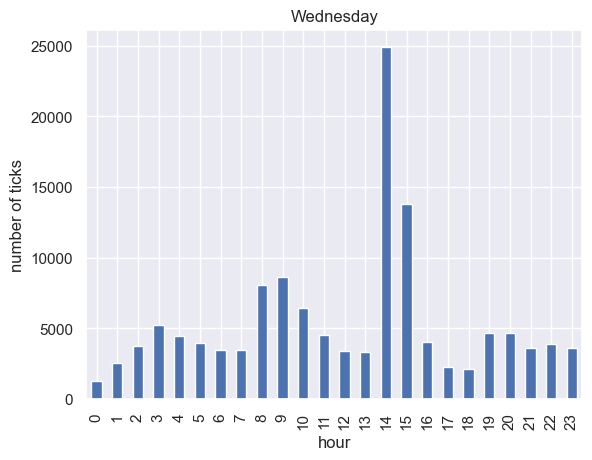

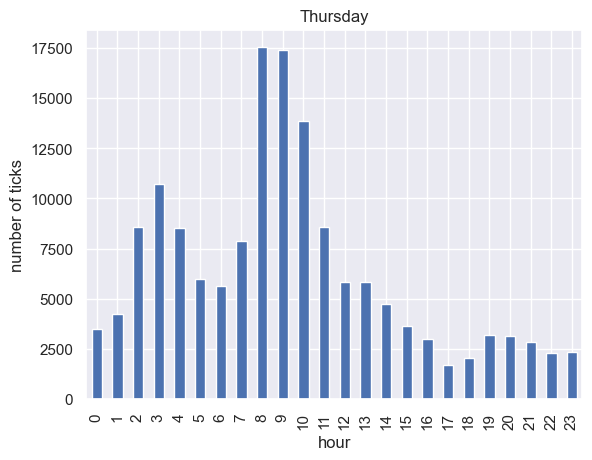

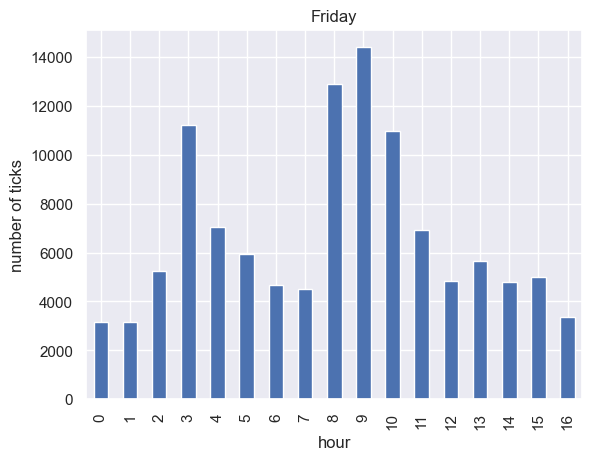

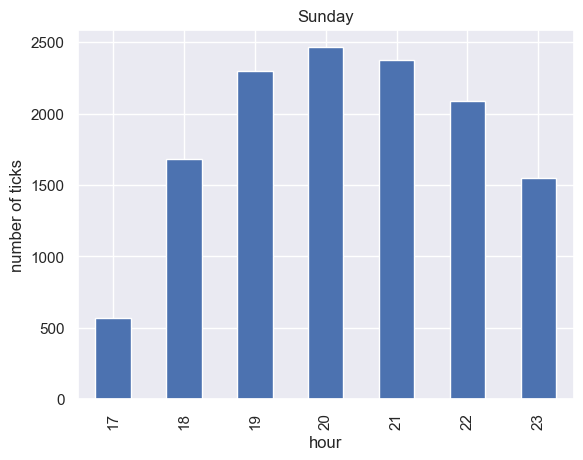

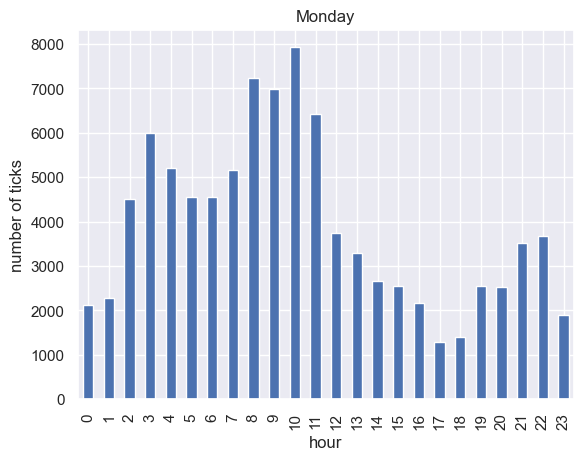

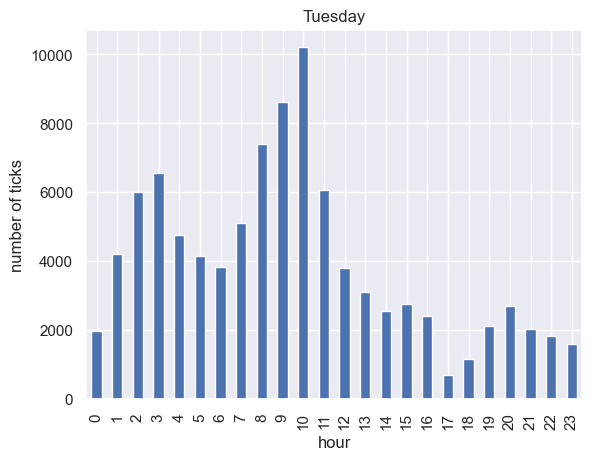

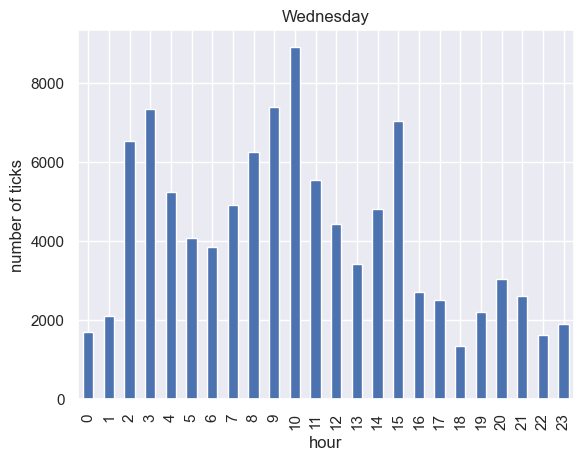

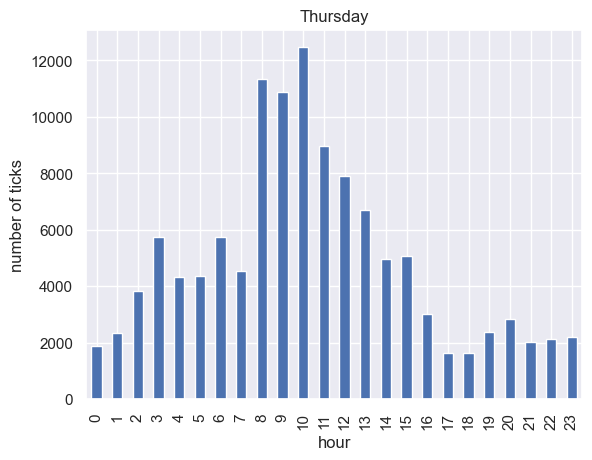

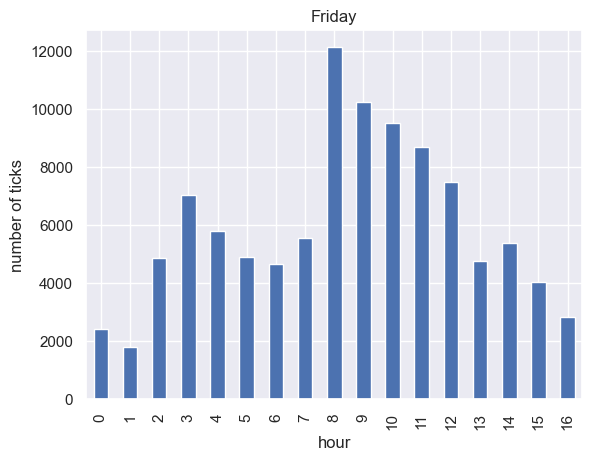

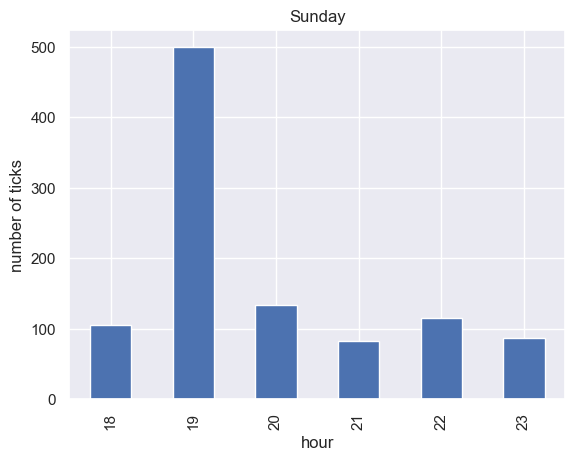

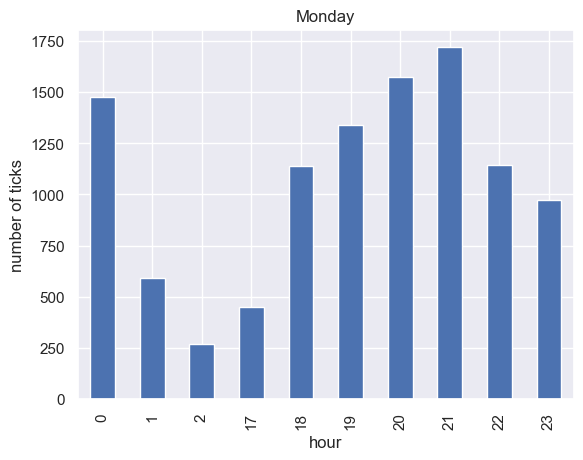

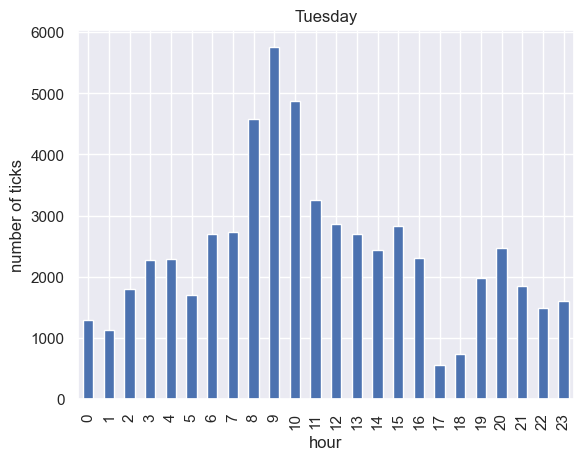

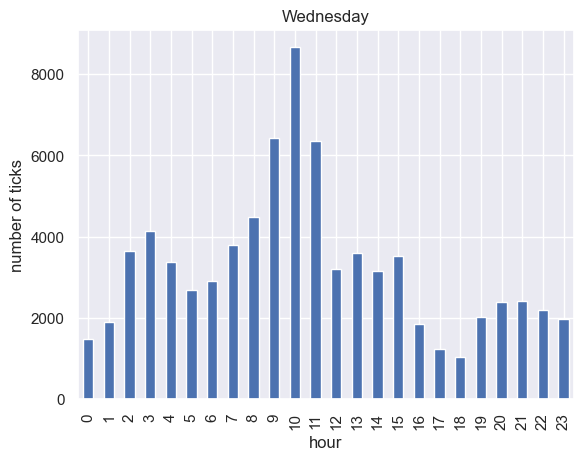

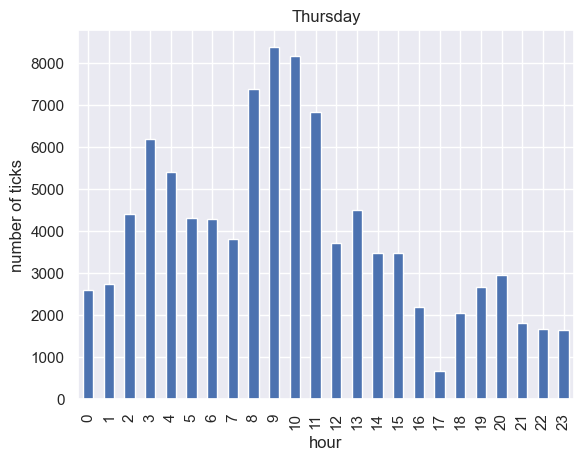

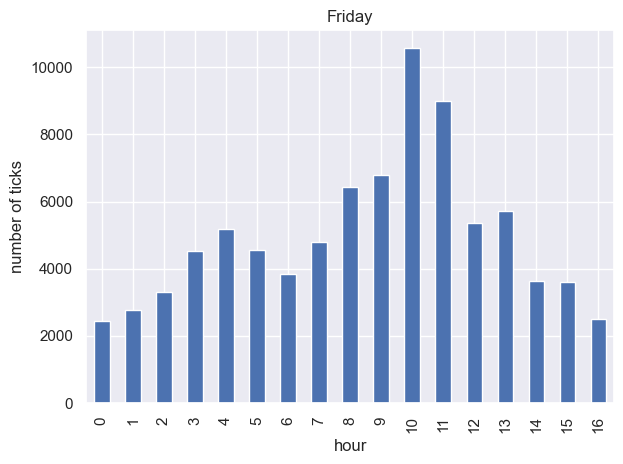

In [296]:
# oneday['hour'] = oneday['timestamp'].dt.hour
for day in df['date'].unique():
    d = df[df['date']==day]
    wday = d['wday'].iloc[0]
    plt.figure()
    plt.title(wday)
    d.groupby('hour')['timestamp'].count().plot(kind='bar')
    plt.ylabel('number of ticks')
plt.tight_layout()
plt.show()

In [297]:
def compute_variogram(df, taus):
    V = np.vectorize(lambda tau: ((df - df.shift(tau))**2).mean())
    # Use the built-in dataframe operations.
    return V(taus)

In [298]:
taus = np.arange(1, 500)
variogram = compute_variogram(oneday['mid'], taus)

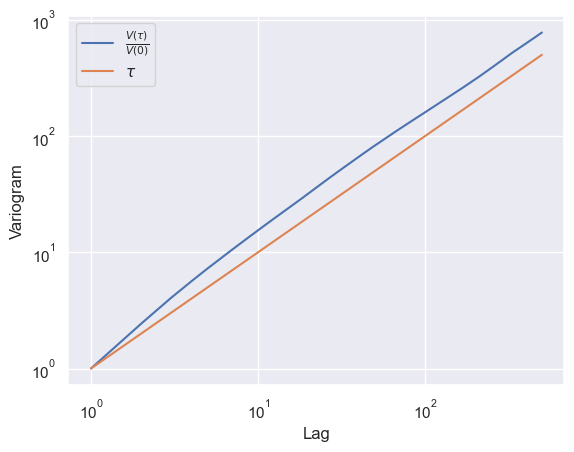

In [299]:
# plot variogram
plt.plot(taus, variogram/variogram[0], label=r'$\frac{V(\tau)}{V(0)}$')
plt.plot(taus, taus, label=r'$\tau$')
plt.xlabel('Lag')
plt.ylabel('Variogram')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

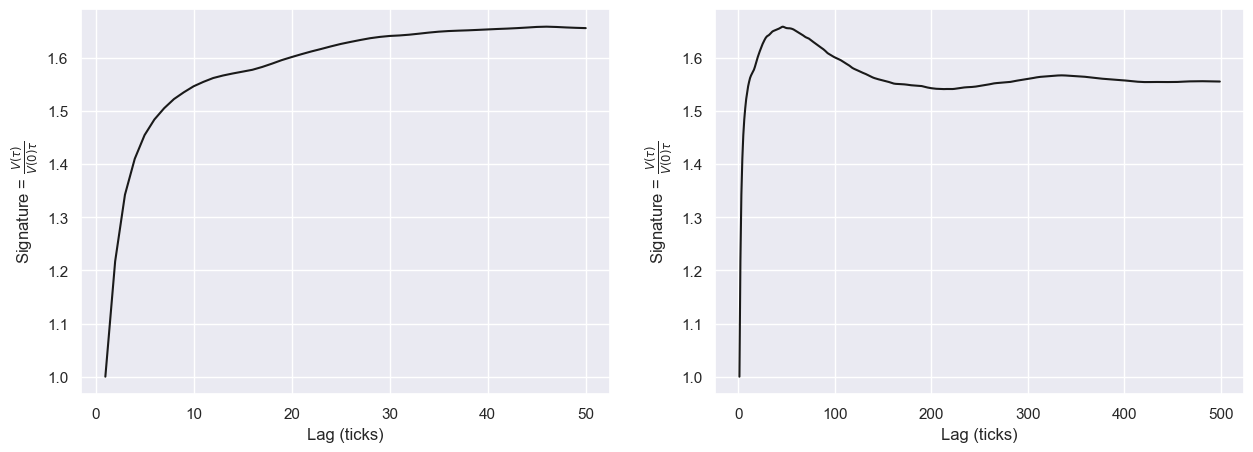

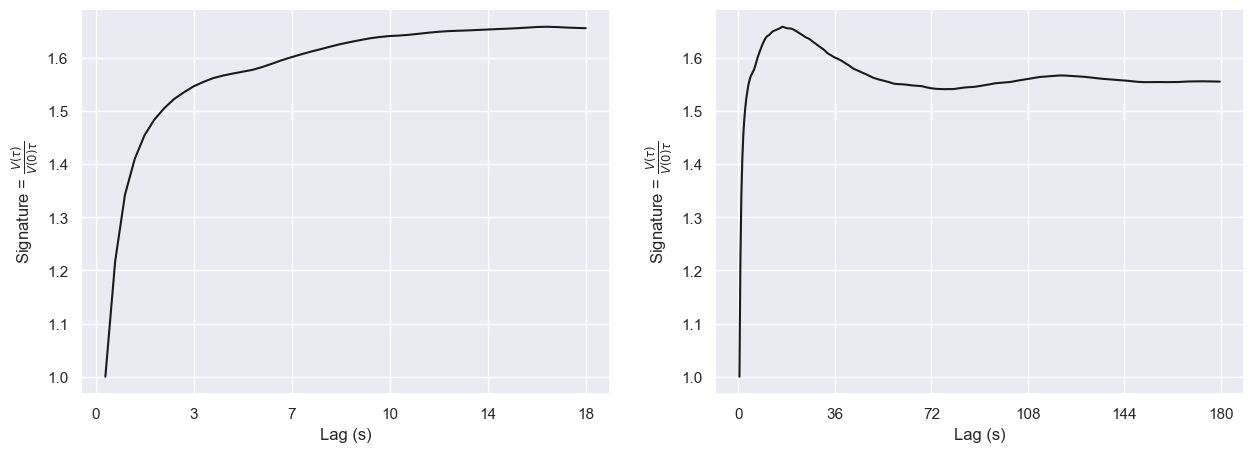

In [304]:
signature = variogram / variogram[0] / taus

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, max_lag in enumerate([50, 500]):
    ax = axs[i]
    ax.plot(taus[:max_lag], signature[:max_lag], label=f'max_lag={max_lag}', c='k')
    ax.set_xlabel('Lag (ticks)')
    ax.set_ylabel(r'Signature = $\frac{V(\tau)}{V(0)\tau}$')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, max_lag in enumerate([50, 500]):
    ax = axs[i]
    ax.plot(taus[:max_lag], signature[:max_lag], label=f'max_lag={max_lag}', c='k')
    ax.set_xlabel('Lag (s)')
    ax.set_ylabel(r'Signature = $\frac{V(\tau)}{V(0)\tau}$')

    # multiply xlabels by 0.6 to get seconds (since 1 tick is about 0.6 seconds)
    if max_lag == 50:
        ax.set_xticks([0, 10, 20, 30, 40, 50])
    else:
        ax.set_xticks([0, 100, 200, 300, 400, 500])
    ax.set_xticklabels([f'{int(x*avg_tick_time*0.6)}' for x in ax.get_xticks()])

plt.show()

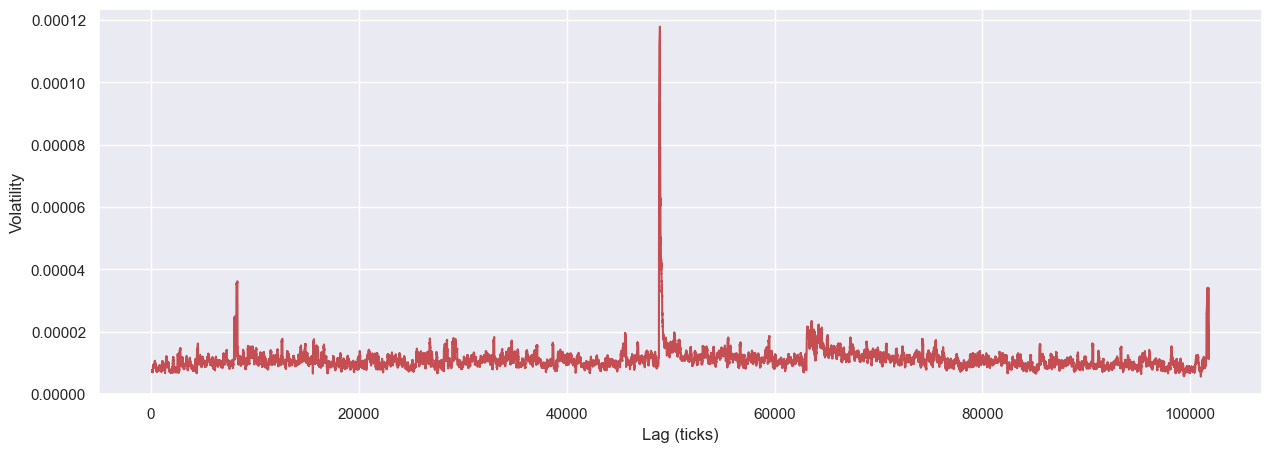

In [302]:
window = 100
volatility = oneday['ret'].rolling(window).std()


fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(oneday['ret'], label='return', c='k')
ax.plot(volatility, label='volatility', c='r')
ax.set_xlabel('Lag (ticks)')
ax.set_ylabel('Volatility')
plt.show()

comprendre l'écart de temps entre lags. Est-il constant ou bien dépend-il des ticks???

In [303]:
oneday['timestamp'].diff().dt.total_seconds()

1           NaN
2         0.052
3         0.103
4         0.053
5         0.154
          ...  
101788    8.751
101789    1.059
101790    6.880
101791    6.822
101792    0.103
Name: timestamp, Length: 101792, dtype: float64

données sales: il manque des bouts de plusieurs seconds parfois! (ce qui peut représenter une centaine de ticks...)

In [328]:
new_df = pd.read_csv('../datasets/new_EURUSD/EURUSD_M1.csv', sep='\t')

In [329]:
new_df

,Time,Open,High,Low,Close,Volume
0,2023-12-06 06:17:00,1.07925,1.07933,1.07923,1.07931,139
1,2023-12-06 06:18:00,1.07932,1.07936,1.07930,1.07930,104
2,2023-12-06 06:19:00,1.07931,1.07931,1.07929,1.07930,51
3,2023-12-06 06:20:00,1.07930,1.07936,1.07930,1.07935,79
4,2023-12-06 06:21:00,1.07935,1.07936,1.07921,1.07921,80
...,...,...,...,...,...,...
99995,2024-03-14 15:55:00,1.08867,1.08867,1.08848,1.08858,395
99996,2024-03-14 15:56:00,1.08859,1.08875,1.08857,1.08859,366
99997,2024-03-14 15:57:00,1.08856,1.08868,1.08852,1.08866,322
99998,2024-03-14 15:58:00,1.08867,1.08887,1.08866,1.08881,329
